<a href="https://colab.research.google.com/github/MarcosMurguel/IC_Redes_Neurais_Profundas_ALL/blob/main/Redes_Neurais_Profundas_Aplicadas_no_Diagn%C3%B3stico_de_Leucemia_Linfobl%C3%A1stica_Aguda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Projeto: Redes Neurais Profundas Aplicadas no Diagnóstico de Leucemia Linfoblástica Aguda


## 1) Importando as biblitecas utilizadas no projeto.

In [11]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import glob
import tensorflow.keras as kr
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input as prepVGG
from tensorflow.keras.applications.resnet50 import preprocess_input as prepResNet
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, models
from tensorflow.keras import layers, activations, initializers
from tensorflow.python.framework import tensor_shape
from tensorflow.python.keras.engine.input_spec import InputSpec

## 2) Conectando ao Google Drive.

Conectamos ao Drive, onde está nosso conjunto de dados. Além disso, aplicamos o pré-processamento tanto da VGG quanto da ResNet no nosso conjunto de dados para treinamento.

In [13]:
from google.colab import drive
drive.mount('/content/drive')

image_size = (224,224)
# dataset_path = "/content/drive/MyDrive/img/*"
dataset_path = "/content/drive/MyDrive/img/*"

imgs_list = [f for f in glob.glob(dataset_path)]
N = len(imgs_list)
print("Número de Imagens:",N)

X = np.zeros((N,image_size[0],image_size[1],3))
Y = np.zeros((N,))

for i, img_path in enumerate(imgs_list):
  img =  image.load_img(img_path, target_size = image_size)
  X[i] = image.img_to_array(img)
  ind = img_path.find(".tif")
  Y[i] = int(img_path[ind-1])

X_VGG = prepVGG(X)
X_ResNet = prepResNet(X)

print("Número de Linfoblastos:",int(np.sum(Y)))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Número de Imagens: 260
Número de Linfoblastos: 130


## 3) Fazendo os dowloads dos modelos pré-treinados.

Veja que em 'include_top' deixamos igual a False, pois iremos montar nossa própia camada de classificação para cada um dos modelos. Essa tarefa nos da um passo para o Transfer Learning, que consiste em adaptar um modelo a um outro problema, fazendo a 'trânsferencia de aprendizado' e aplicando em nosso problema de LLA.

### 3.1) Importando a base do modelo VGG.

In [14]:
modelo_base_VGG  = tf.keras.applications.VGG16(
    include_top=False, #nesta parte trazemos as camadas fully connecteds para classficação
    weights="imagenet",
)

modelo_base_VGG.trainable = False

#### 3.1.1) Dando uma olhada na construção do modelo base da VGG :)

In [15]:
modelo_base_VGG.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 3.2) Importando a base do modelo ResNet.

In [16]:
modelo_base_ResNet = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
)

modelo_base_ResNet.trainable = False

#### 3.2.1) Dando uma olhada na construção do modelo base da ResNet :)

In [17]:
modelo_base_ResNet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_4[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

## 4) Extraindo características das imagens utilizando os modelos.

In [18]:
features_VGG = modelo_base_VGG.predict(X_VGG[0:3])

1/1 [==============================] - 8s 8s/step


In [19]:
features_ResNet =  modelo_base_ResNet.predict(X_ResNet[0:3])

1/1 [==============================] - 1s 1s/step


## 5) Dividindo nosso conjunto de dados em treino e teste.

Utilizamos o random_state para assegurarmos que todos os modelos tenham a mesma entrada, assim conseguimos aferir a qualidade dos mesmos. Separamos o treino e teste a partir dos dados X_VGG e X_ResNet com seus respectivos dados pré processados, vide parte 1 do documento, já para CNN separamos a partir do X obtido também no passo 1.

In [20]:
Xtr_VGG, Xte_VGG, Ytr_VGG, Yte_VGG = train_test_split(X_VGG, Y, test_size=0.5, random_state=1234)

In [21]:
Xtr_ResNet, Xte_ResNet, Ytr_ResNet, Yte_ResNet = train_test_split(X_ResNet, Y, test_size=0.5, random_state=1234)

In [22]:
Xtr_CNN, Xte_CNN, Ytr_CNN, Yte_CNN = train_test_split(X, Y, test_size=0.5, random_state=1234)

## 6) Criando o modelo CNN.

Diferentemente dos modelos VGG e ResNet, o nosso modelo de CNN iremos criar a partir zero, utilizando a biblioteca keras. A seguir, criamos nosso modelo CNN com quatro camadas convolucionais e quatro MaxPoolings.

In [23]:
model_CNN = kr.Sequential(
        [
            layers.Conv2D(8, kernel_size=(3, 3), activation="relu", input_shape=Xtr_CNN.shape[1:]),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(1, activation=None)
        ]
    )

## 6.1) Dando uma olhada na construção do modelo ResNet :)

In [24]:
model_CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 16)        2320      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 16)       0

## 7) Usando os modelos base.

Agora, criamos o nossos modelos para VGG e ResNet utilizando o modelo base respectivo, adicionando nossas camadas de classificação e modelando a nossa rede para nosso problema, veja que como temos um problema de classificação binária, a ultima camada conta apenas com um neurónio.

In [25]:
model_VGG = tf.keras.Sequential([
    tf.keras.Input(shape=(224,224,3)),
    modelo_base_VGG,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(1, activation=None)
])

model_VGG.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 4096)              102764544 
                                                                 
 dense_2 (Dense)             (None, 4096)              16781312  
                                                                 
 dense_3 (Dense)             (None, 1)                 4097      
                                                                 
Total params: 134,264,641
Trainable params: 119,549,953
Non-trainable params: 14,714,688
_________________________________________________________________


In [26]:
model_ResNet = tf.keras.Sequential([
    tf.keras.Input(shape=(224,224,3)),
    modelo_base_ResNet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation=None)
])

model_ResNet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_4 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


## 8) Adicionando os hiperparâmetros para nosso modelos

Nossa função de perda será a Binary Cross Entropy, também chamada de Log Loss, descrita por:

\begin{equation}
H_{p}(q) = - \frac{1}{N} \sum_{i = 1}^{N}y_i \cdot log(p(y_i)) + (1-y_i) \cdot log(1 - p(y_i))
\end{equation}

Onde o $y$ representa a classe/rótulo, 0 ou 1, e $p(y)$ representa a previsão de probabilidade do ponto ser de determinada classe.

Veja que aplicamos os mesmos hiperparâmetros para todos modelos.

In [27]:
model_VGG.compile(optimizer='adam',
      loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
      metrics=[tf.keras.metrics.BinaryAccuracy()])

In [28]:
model_ResNet.compile(optimizer='adam',
      loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
      metrics=[tf.keras.metrics.BinaryAccuracy()])

In [29]:
model_CNN.compile(optimizer='adam',
      loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
      metrics=[kr.metrics.BinaryAccuracy()])

## 9) Aplicando a técnica de Datagen.

A técnica consiste em gerar novos dados, artificilamente, rotacionando vertical e horizontalmente nosso dados, neste caso. Uitlizando esta ténica, conseguimos potencializar a generalização dos modelos para prever classes que se distinguem de um padrão de entrada: por exemplo, o modelo só receber fotos de árvores em pé, mas em algum momento o modelo receber uma imagem de uma árvore virada de lado, sabemos que está imagem continua sendo de uma árvore, mas talvez seu modelo tenha assimilado a posição da imagem como uma feature de detectação, atrapalhando assim a generalização do modelo, técnicas de datagen além de aumentar o conjunto de dados nos ajudam com este problema.

In [30]:
datagen_VGG = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True)
datagen_VGG.fit(Xtr_VGG)
it = datagen_VGG.flow(Xtr_VGG, Ytr_VGG, batch_size=32)
batch = it.next()

datagen_ResNet = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True)
datagen_ResNet.fit(Xtr_ResNet)
it = datagen_ResNet.flow(Xtr_ResNet, Ytr_ResNet, batch_size=32)
batch = it.next()

datagen_CNN = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True)
datagen_CNN.fit(Xtr_CNN)
it = datagen_CNN.flow(Xtr_CNN, Ytr_CNN, batch_size=32)
batch = it.next()

## 10) Treinando os modelos.

In [31]:
VGG = model_VGG.fit(datagen_VGG.flow(Xtr_VGG, Ytr_VGG, batch_size=32),epochs=300,verbose=1,validation_data=(Xte_VGG, Yte_VGG))

Epoch 1/300
5/5 [==============================] - 9s 558ms/step - loss: 185.3682 - binary_accuracy: 0.6000 - val_loss: 8.5888 - val_binary_accuracy: 0.7308
Epoch 2/300
5/5 [==============================] - 1s 281ms/step - loss: 5.9736 - binary_accuracy: 0.8385 - val_loss: 10.2866 - val_binary_accuracy: 0.7154
Epoch 3/300
5/5 [==============================] - 1s 284ms/step - loss: 9.4623 - binary_accuracy: 0.7923 - val_loss: 6.0854 - val_binary_accuracy: 0.8231
Epoch 4/300
5/5 [==============================] - 1s 276ms/step - loss: 2.2440 - binary_accuracy: 0.9231 - val_loss: 12.2402 - val_binary_accuracy: 0.7231
Epoch 5/300
5/5 [==============================] - 1s 248ms/step - loss: 4.6222 - binary_accuracy: 0.8692 - val_loss: 17.7687 - val_binary_accuracy: 0.5923
Epoch 6/300
5/5 [==============================] - 1s 278ms/step - loss: 2.2616 - binary_accuracy: 0.9077 - val_loss: 6.2223 - val_binary_accuracy: 0.7000
Epoch 7/300
5/5 [==============================] - 1s 248ms/step 

In [32]:
ResNet = model_ResNet.fit(datagen_ResNet.flow(Xtr_ResNet, Ytr_ResNet, batch_size=32),epochs=300,verbose=1,validation_data=(Xte_ResNet, Yte_ResNet))

Epoch 1/300
5/5 [==============================] - 8s 602ms/step - loss: 0.9412 - binary_accuracy: 0.4538 - val_loss: 0.9192 - val_binary_accuracy: 0.4615
Epoch 2/300
5/5 [==============================] - 1s 189ms/step - loss: 0.7412 - binary_accuracy: 0.5308 - val_loss: 0.7314 - val_binary_accuracy: 0.5077
Epoch 3/300
5/5 [==============================] - 1s 192ms/step - loss: 0.6212 - binary_accuracy: 0.6231 - val_loss: 0.6997 - val_binary_accuracy: 0.5000
Epoch 4/300
5/5 [==============================] - 1s 246ms/step - loss: 0.5539 - binary_accuracy: 0.6154 - val_loss: 0.6081 - val_binary_accuracy: 0.6077
Epoch 5/300
5/5 [==============================] - 1s 251ms/step - loss: 0.4851 - binary_accuracy: 0.7462 - val_loss: 0.5779 - val_binary_accuracy: 0.7385
Epoch 6/300
5/5 [==============================] - 1s 189ms/step - loss: 0.4381 - binary_accuracy: 0.8000 - val_loss: 0.5315 - val_binary_accuracy: 0.7000
Epoch 7/300
5/5 [==============================] - 1s 250ms/step - los

In [33]:
CNN = model_CNN.fit(datagen_CNN.flow(Xtr_CNN, Ytr_CNN, batch_size=32),epochs=300,verbose=1,validation_data=(Xte_CNN, Yte_CNN))

Epoch 1/300
5/5 [==============================] - 5s 189ms/step - loss: 7.8196 - binary_accuracy: 0.4846 - val_loss: 0.5897 - val_binary_accuracy: 0.7385
Epoch 2/300
5/5 [==============================] - 0s 57ms/step - loss: 1.7415 - binary_accuracy: 0.6692 - val_loss: 0.4941 - val_binary_accuracy: 0.7385
Epoch 3/300
5/5 [==============================] - 0s 63ms/step - loss: 0.8476 - binary_accuracy: 0.7154 - val_loss: 0.4456 - val_binary_accuracy: 0.7769
Epoch 4/300
5/5 [==============================] - 0s 49ms/step - loss: 0.6962 - binary_accuracy: 0.7000 - val_loss: 0.4909 - val_binary_accuracy: 0.7615
Epoch 5/300
5/5 [==============================] - 0s 55ms/step - loss: 0.6106 - binary_accuracy: 0.6923 - val_loss: 0.4657 - val_binary_accuracy: 0.7538
Epoch 6/300
5/5 [==============================] - 0s 50ms/step - loss: 0.4840 - binary_accuracy: 0.7385 - val_loss: 0.4678 - val_binary_accuracy: 0.7385
Epoch 7/300
5/5 [==============================] - 0s 47ms/step - loss: 0.4

## 11) Plotando o gráfico da relação entre acurácia e função de perda que é inversamente proporcional.

Aqui podemos notar a inconstância da função de perda quando analisamos a CNN, enquanto a ResNet parece convergir de forma mais fluída.

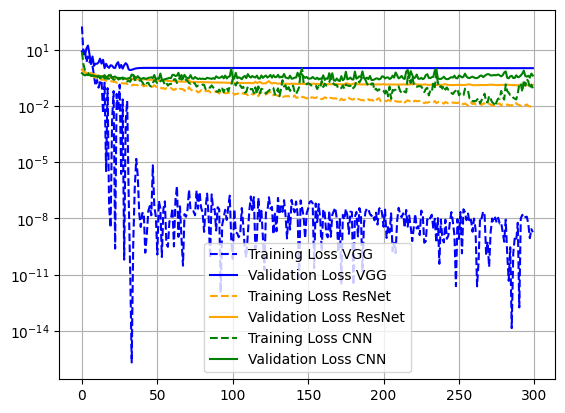

In [34]:
plt.semilogy(VGG.history['loss'], label='Training Loss VGG',color="blue",linestyle="dashed")
plt.semilogy(VGG.history['val_loss'], label='Validation Loss VGG',color="blue")
plt.semilogy(ResNet.history['loss'], label='Training Loss ResNet',color="orange",linestyle="dashed")
plt.semilogy(ResNet.history['val_loss'], label='Validation Loss ResNet',color="orange")
plt.semilogy(CNN.history['loss'], label='Training Loss CNN',color="green",linestyle="dashed")
plt.semilogy(CNN.history['val_loss'], label='Validation Loss CNN',color="green")
# plt.ylim([1.e-6, 100])
plt.legend()
plt.grid()
plt.legend()

## 12) Plotando o gráfico da relação entre treino e teste.

Aqui temos uma relação entre o treino e teste, em suma, um bom algorítimo deve 'aprender' com seus dados de treino e, ao encontrar uma instância nova, conseguir classifica-la com baixa taxa de erros. Quando temos um algorítimo que acerta muito no treino, mas erra muito no teste, temos um forte indicativo de overffiting (sobreajuste). Já, quando temos muitos erros no treino e no teste, temos um forte indicativo de underfitting (subajuste). Queremos, em um bom modelo, evitar ambos os casos tendo um bom trade-off entre o vies e a variância de nossos dados.

Veja, que um bom exemplo visual de overfitting se aplica a rede CNN, seus dados de treino (verde contínuo) estão bem mais elevados que seus dados de teste (verde tracejado), indicando, muito provavelmente, que o modelo se sobreajustou aos dados de treino e não conseguiu generalizar o modelo para prever as novas instâncias imputadas.

Analisando nossa métrica de avaliação do modelo para o teste, podemos ver que a VGG se estabiliza em um valor a partir de um certo momento do aprendizado. Já nossa rede ResNet, continua, com o passar dos epochs, mudando seu valor de acurácia. Veja que no epoch 300, do melhor para o melhor em relação a nossa acurácia, temos: ResNet, VGG e CNN

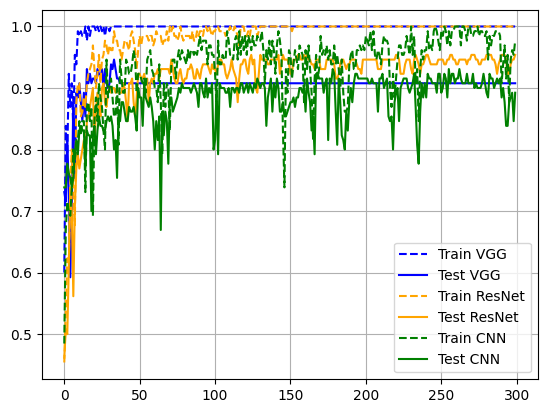

In [35]:
plt.plot(VGG.history['binary_accuracy'], label='Train VGG',color="blue",linestyle="dashed")
plt.plot(VGG.history['val_binary_accuracy'], label='Test VGG',color="blue")
plt.plot(ResNet.history['binary_accuracy'], label='Train ResNet',color="orange",linestyle="dashed")
plt.plot(ResNet.history['val_binary_accuracy'], label='Test ResNet',color="orange")
plt.plot(CNN.history['binary_accuracy'], label='Train CNN',color="green",linestyle="dashed")
plt.plot(CNN.history['val_binary_accuracy'], label='Test CNN',color="green")
plt.grid()
plt.legend()

## 13) Conclusão Final.

Utilizando deste dois últimos gráficos, podemos perceber que tanto a ResNet como a VGG tem um desempenho maior se comparadas com a CNN. Percemos também que a VGG sofreu com overfitting enquanto a CNN apresentou um certo tipo de underfit. Além disso, podemos concluír que a ResNet supera a VGG tanto em métrica de avaliação, quanto em consistência relacionada ao treino e teste.

No final, conseguimos perceber que a ResNet se sobressaí e para nosso objetivo, classificar se uma pessoa tem ou não LLA, foi o melhor modelo.